10.2 温度预测

本章中所有的代码都针对一个问题: 预测未来 24h 后温度

给定的是大气压力湿度的小时测量数据,这会是一个具有相当挑战性的任务.

现在我们接触过的 全连接网络 和 卷积神经网络 并不能很好的处理时间序列数据.因此需要新的网络类型 RNN 循环神经网络.


In [1]:
# !wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
# !unzip jena_climate_2009_2016.csv.zip

linux 上可以直接运行,win 下面要手动下载数据了.

我们使用的是德国 Max Planck Institute for Biogeochemistry 的数据集,这个数据集每 10 分钟记录 14 种数据,持续数年.最早的数据可以追溯到 2003 年,但是这里我们只是用 2009~2016 年的数据.


In [2]:
import os

fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


420451 行数据

每行数据对应上面的种类的顺序.


In [3]:
import numpy as np

temperature = np.zeros((len(lines), ))  #全0 数组
raw_data = np.zeros((len(lines), len(header) - 1))  #全0 数组
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]  #每行的第一个值是时间戳，所以从第二个开始
    temperature[i] = values[1]  #第一个值是温度
    raw_data[i, :] = values[:]  #每行的数据


我们将所有的数据都转换成了 numpy 数组

- 第一个值是温度
- 其他是气象原始数据
- 注意我们  舍弃了时间戳


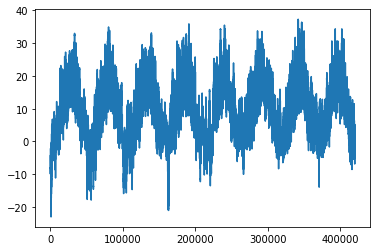

In [4]:
from matplotlib import pyplot as plt

plt.plot(range(len(temperature)), temperature)

绘制出 8 年全部数据,可以看到周期性的变换.


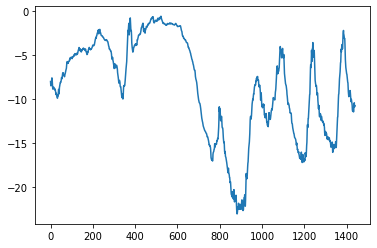

In [5]:
plt.plot(range(1440), temperature[:1440])

数据是 10分钟/个 速度来的,这里 1440 个是 10 天.的温度曲线

都是 0 下数据,应该是寒冷的冬天.


粗看数据,似乎周期是以年为单位的,几天内没有那么体现周期性,那么使用这些数据可以预测将来几天的温度吗?


In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


训练集/验证集/测试集 从前到后比例是 2:1:1.

处理时序数据,时间的前后非常重要,我们是使用过去数据预测未来,而不是相反.数据集划分要非常明确区分.


## 准备数据

这一节的问题: 给定 5 天的数据,我们能预测未来 24h 后的温度吗?


In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

我们使用前 50% 的数据训练

- 数据已经是数值了,无需转换.
- 但是和波士顿房价数据集一样,各个指标的取值范围军不同,需要独立进行规范化


原问题是使用 5 天的数据预测未来 24h 后温度.数据集有很多冗余(训练集就是 4 年的数据),我们无需为每个样本都直接塞到内存,浪费空间.我们在训练时使用迭代器,动态的加载需要的样本.

通常我们手动实现一个迭代器容易,但是 keras 有相应的工具 `timeseries_dataset_from_array`,一般而言,我们可以将其用在任何种类的时间序列预测任务上.


`timeseries_dataset_from_array` 是将传入的时序数据做成迭代器返回.假设参数 `data = [0 1 2 3 4 5 6]`

- 按照窗口大小返回数据 `sequence_length=3` -> `[0 1 2]` `[1 2 3]` `[2 3 4]` `[3 4 5]` `[4 5 6]`
- 按照窗口大小,生成预测序列 `sequence_length=3` and `targets = [3 4 5 6 …]` -> `[0, 1, 2] 3` `[1, 2, 3] 4` `[2, 3, 4] 5` `[3, 4, 5] 6`

---

`timeseries_dataset_from_array` 给我感觉非常像流数据处理...

---


In [8]:
from tensorflow import keras

In [9]:
sampling_rate = 6  # 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)  #24小时后
batch_size = 256

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.preprocessing.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.preprocessing.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

对 `timeseries_dataset_from_array` 参数是这样的

- `sampling_rate = 6`: 6 个数据保留 1 个,这样时间间隔变成 1h.
- `sequence_length = 120`: 每个样本长度是 120 也就是 120h = 5days
- `delay = sampling_rate * (sequence_length + 24 - 1)` `targets=temperature[delay:]`: 一个序列的目标值是这个序列结束后 24h = 1day 的数据.


In [10]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


一个样本是一个元组 `(samples, targets)`,一个批次大小是 256,每个样本包含 120 行 = 120h = 5days 的数据.每个 targets 批次大小是 256.包含序列 24h 后温度.


## 非机器学习基线


In [11]:
# np.mean(np.abs(preds - targets))

In [12]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen


print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


我们这里使用了一个假设,假设 24 小时后与现在温度相等.然后计算平方绝对误差 MAE.

效果不算太糟糕,在验证集上是 2.44 测试集上是 2.62.等价于偏离了 2.5°C.

让我们尝试一下机器学习的方法.


## 全连接模型

按照前文学过的内容,解决一个问题,第一个要建立的模型是基础模型,简单的验证.


In [15]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)  #全连接
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)  #保存模型
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,  #训练10个周期
    validation_data=val_dataset,
    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 13s 14ms/step - loss: 12.1273 - mae: 2.6982 - val_loss: 13.1381 - val_mae: 2.8680
Epoch 2/10
819/819 [==============================] - 11s 14ms/step - loss: 8.9028 - mae: 2.3445 - val_loss: 10.8591 - val_mae: 2.6079
Epoch 3/10
819/819 [==============================] - 12s 14ms/step - loss: 8.1593 - mae: 2.2482 - val_loss: 12.2641 - val_mae: 2.7842
Epoch 4/10
819/819 [==============================] - 11s 14ms/step - loss: 7.7400 - mae: 2.1885 - val_loss: 12.2124 - val_mae: 2.7805
Epoch 5/10
819/819 [==============================] - 11s 14ms/step - loss: 7.4139 - mae: 2.1424 - val_loss: 13.8626 - val_mae: 2.9492
Epoch 6/10
819/819 [==============================] - 11s 13ms/step - loss: 7.1827 - mae: 2.1108 - val_loss: 10.9390 - val_mae: 2.6144
Epoch 7/10
819/819 [==============================] - 11s 13ms/step - loss: 7.0089 - mae: 2.0845 - val_loss: 11.9571 - val_mae: 2.7285
Epoch 8/10
819/819 [==============================] - 

模型

- 仅仅只有一个全连接层.
- 使用 MSE 作为损失.
- 最后一层没有激活函数,这是个回归问题.


In [16]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")  #评估模型


405/405 [==============================] - 4s 8ms/step - loss: 12.1080 - mae: 2.7311
Test MAE: 2.73


效果还不如基线..


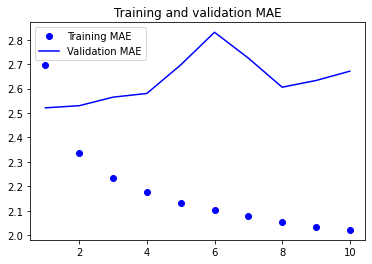

In [14]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

从图上看,似乎模型很快就过拟合了,这样简单的模型效果与基线差不多,或者更差.

这里有个疑惑,如果在上面的模型所有可能的搜索空间内存在从数据到目标的良好映射,为什么模型找不到?结果这么糟糕.

一组良好的映射参数,几乎是大海捞针.梯度下降并不意味着一定能找到.

机器学习一个非常严重的限制: 除非学习算法被硬编码成了寻找特定的简单模型,否则算法有时并不会为简单问题找到简单解决.这就是为什量化的特征工程和工程表现良好的先验架构非常重要的原因,我们需要精确的告诉模型到底在寻找什么.


## 1D 卷积模型

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras", save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 21s 20ms/step - loss: 23.4666 - mae: 3.7955 - val_loss: 16.7761 - val_mae: 3.2323
Epoch 2/10
819/819 [==============================] - 16s 19ms/step - loss: 15.8701 - mae: 3.1573 - val_loss: 17.6518 - val_mae: 3.2965
Epoch 3/10
819/819 [==============================] - 15s 18ms/step - loss: 14.2133 - mae: 2.9837 - val_loss: 14.5630 - val_mae: 2.9944
Epoch 4/10
819/819 [==============================] - 16s 19ms/step - loss: 13.2777 - mae: 2.8827 - val_loss: 14.0743 - val_mae: 2.9574
Epoch 5/10
819/819 [==============================] - 15s 18ms/step - loss: 12.6165 - mae: 2.8093 - val_loss: 16.7415 - val_mae: 3.2571
Epoch 6/10
819/819 [==============================] - 15s 18ms/step - loss: 12.1109 - mae: 2.7512 - val_loss: 14.0021 - val_mae: 2.9609
Epoch 7/10
819/819 [==============================] - 15s 18ms/step - loss: 11.7054 - mae: 2.7011 - val_loss: 14.8204 - val_mae: 3.0340
Epoch 8/10
819/819 [============================

In [18]:
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 4s 10ms/step - loss: 15.5291 - mae: 3.1118
Test MAE: 3.11


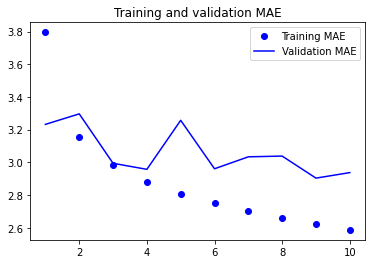

In [19]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

结果更加离谱.似乎卷积网络的卷积操作起了反作用.
